In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,f1_score,recall_score ,precision_score,roc_curve,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Employee.csv")

In [3]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


# EDA

In [4]:
df.rename(columns={'ExperienceInCurrentDomain': 'ECD'}, inplace=True)

In [5]:
df.describe()

,JoiningYear,PaymentTier,Age,ECD,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


In [6]:
df.shape

(4653, 9)

In [7]:
df.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ECD', 'LeaveOrNot'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Education    4653 non-null   object
 1   JoiningYear  4653 non-null   int64 
 2   City         4653 non-null   object
 3   PaymentTier  4653 non-null   int64 
 4   Age          4653 non-null   int64 
 5   Gender       4653 non-null   object
 6   EverBenched  4653 non-null   object
 7   ECD          4653 non-null   int64 
 8   LeaveOrNot   4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [9]:
df.isnull().sum()

Education      0
JoiningYear    0
City           0
PaymentTier    0
Age            0
Gender         0
EverBenched    0
ECD            0
LeaveOrNot     0
dtype: int64

<AxesSubplot:>

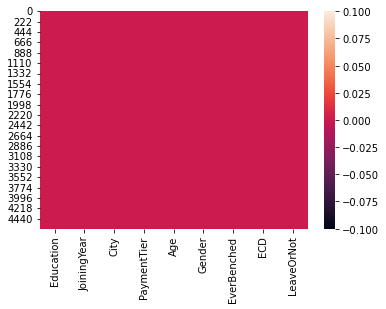

In [10]:
sns.heatmap(df.isnull())

# Categorical Features

In [11]:
labelencoder = preprocessing.LabelEncoder()
df['Education'] = labelencoder.fit_transform(df['Education'])
df['City'] = labelencoder.fit_transform(df['City'])
df['Gender'] = labelencoder.fit_transform(df['Gender'])
df['EverBenched'] = labelencoder.fit_transform(df['EverBenched'])

<AxesSubplot:>

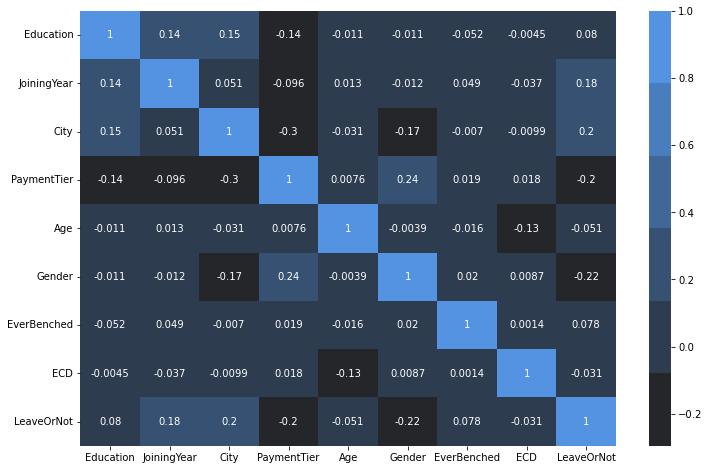

In [12]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr() , annot=True,cmap=sns.dark_palette((250, 75, 60), input="husl"))

### Correlation  is very weak between features !!!

## Data visualization

<AxesSubplot:>

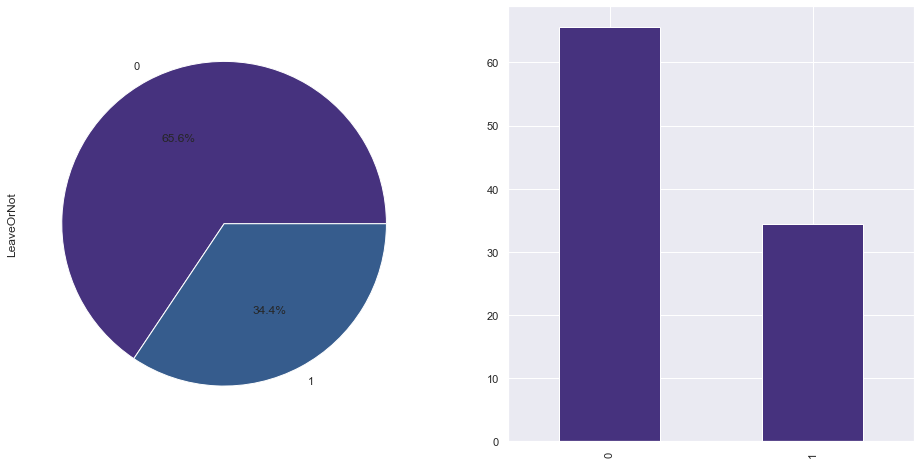

In [13]:
sns.set_theme(palette="viridis")
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
(df['LeaveOrNot'].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[0])
(df['LeaveOrNot'].value_counts(normalize=True)*100).plot.bar(ax=axs[1])

### 0 >>> 65% staying  
### 1 >>> 34% leaving
### imbalnceing in the target

<AxesSubplot:ylabel='None'>

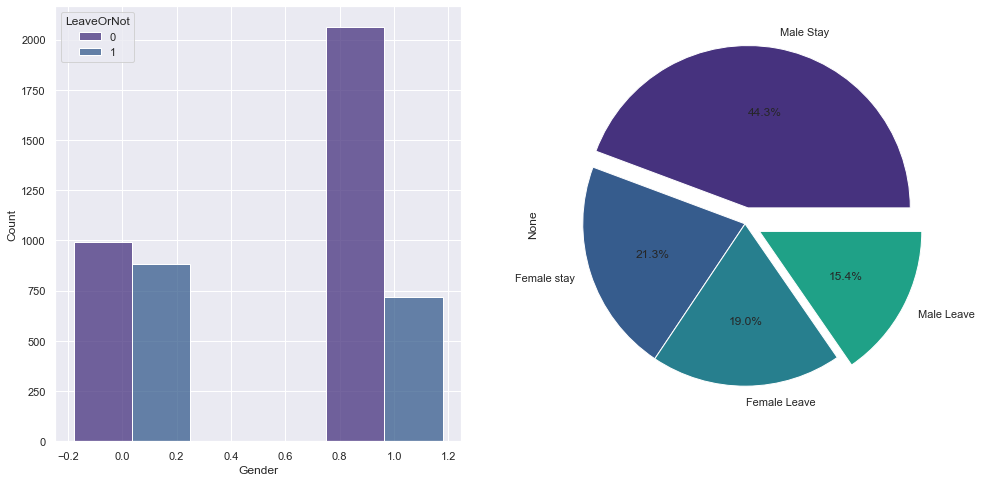

In [14]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
explode = [0.1,0.0,0.0,0.1]
labels = ["Male Stay", "Female stay", "Female Leave", "Male Leave"]
sns.histplot(data=df, x="Gender", hue="LeaveOrNot", multiple="dodge", shrink=6, ax=axs[0])
(df[['Gender','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] ,explode=explode, labels=labels)

### Male >>> 44% staying, 15% leaving
### Female >>> 21% staying, 19% leaving

<AxesSubplot:xlabel='Age', ylabel='Count'>

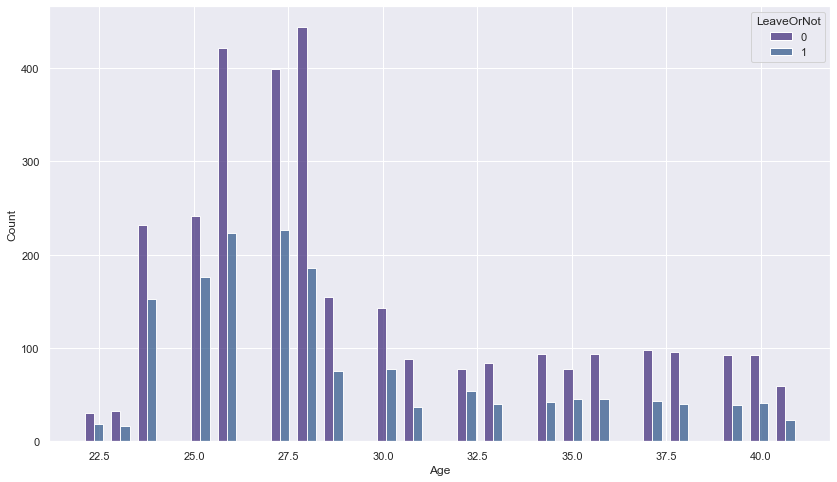

In [15]:
fig, axs= plt.subplots(figsize=(14, 8))
sns.histplot(data=df, x="Age", hue="LeaveOrNot", multiple="dodge", shrink=.7)

### 28 years is the highest and lowest in leaving and staying


<AxesSubplot:xlabel='ECD', ylabel='Count'>

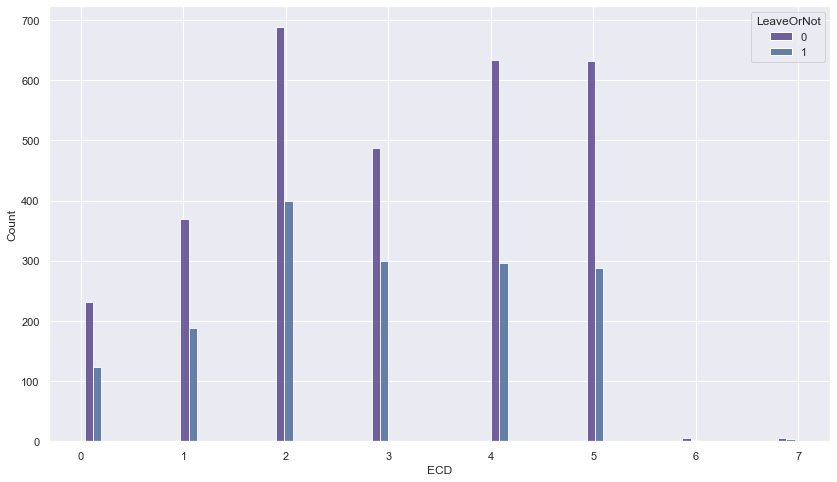

In [16]:
fig, axs= plt.subplots(figsize=(14, 8))
sns.histplot(data=df, x="ECD", hue="LeaveOrNot", multiple="dodge", shrink=0.7)

### 2years exp. >>> highest in staying and leaving

<AxesSubplot:xlabel='PaymentTier', ylabel='Count'>

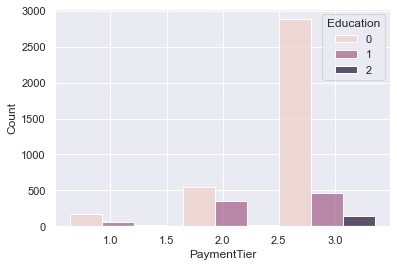

In [17]:
sns.histplot(data=df, x="PaymentTier", hue="Education", multiple="dodge", shrink=6)

<AxesSubplot:ylabel='None'>

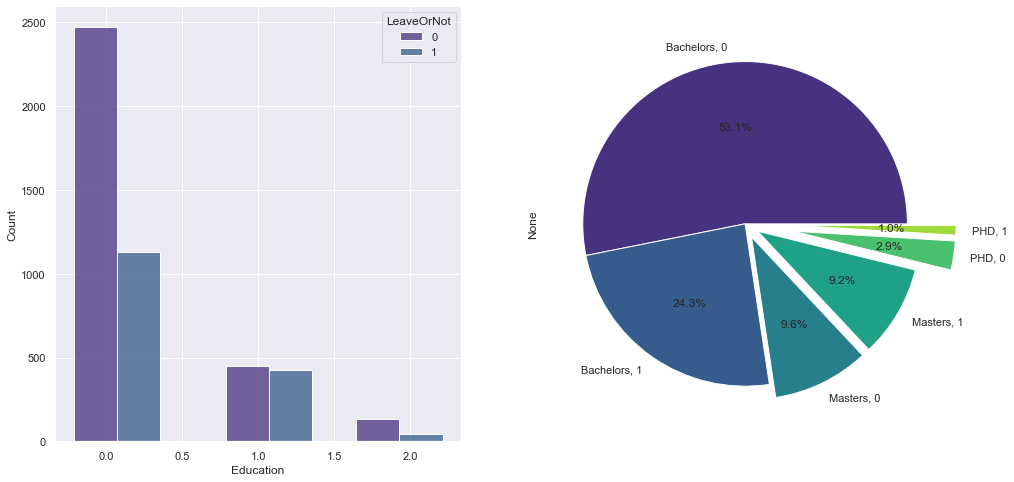

In [18]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
explode = [0.0,0.0,0.09,0.09,0.3,0.3]
labels = ["Bachelors, 0", "Bachelors, 1", "Masters, 0", "Masters, 1" , "PHD, 0" , "PHD, 1"]
sns.histplot(data=df, x="Education", hue="LeaveOrNot", multiple="dodge", shrink=4, ax=axs[0])
(df[['Education','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] ,explode=explode , labels = labels)

### Bachelors >>> 53% Staying , 24%  leaving
### Master >>> 9.2% leaving, 9.2% staying

<AxesSubplot:ylabel='None'>

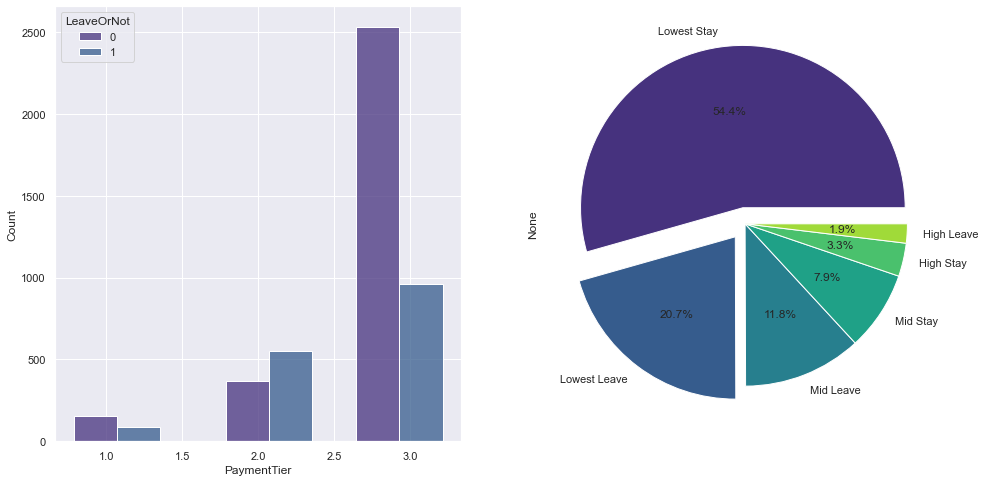

In [19]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
explode = [0.1,0.1,0.0,0.0,0.0,0.0]
labels = ["Lowest Stay", "Lowest Leave", "Mid Leave", "Mid Stay" , "High Stay" , "High Leave"]
sns.histplot(data=df, x="PaymentTier", hue="LeaveOrNot", multiple="dodge", shrink=4, ax=axs[0])
(df[['PaymentTier','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] ,explode=explode , labels = labels)

### The type of  payment tier 
### -1: HIGHEST -2: MID LEVEL -3:LOWEST
### tier payment >>> the lowest 54% staying ,20% leaving


<AxesSubplot:xlabel='PaymentTier', ylabel='Count'>

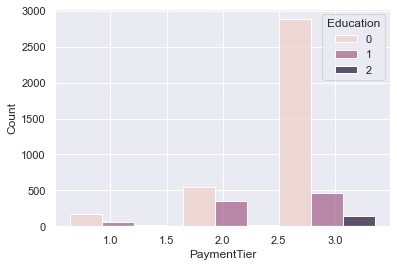

In [20]:
sns.histplot(data=df, x="PaymentTier", hue="Education", multiple="dodge", shrink=6)

<AxesSubplot:ylabel='None'>

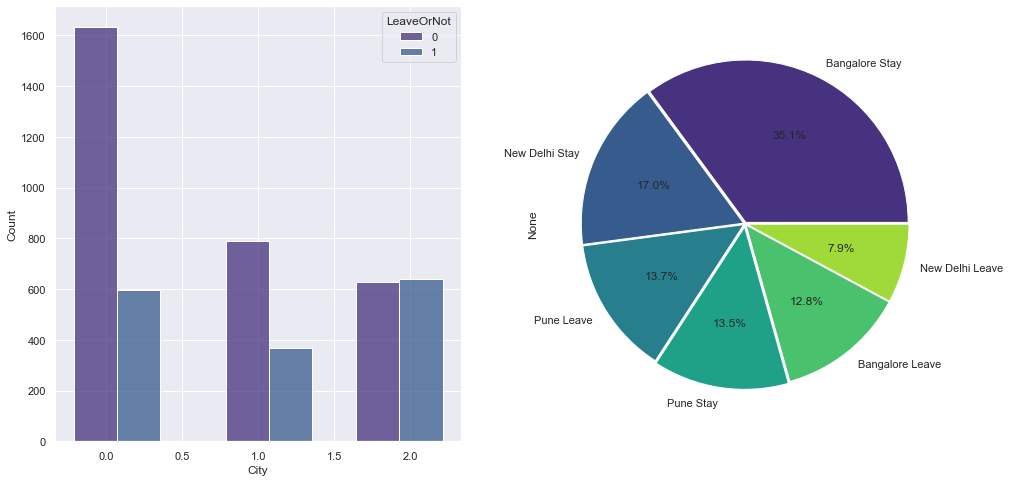

In [21]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
explode = [0.01,0.01,0.01,0.02,0.01,0.01]
labels = ["Bangalore Stay", "New Delhi Stay", "Pune Leave", "Pune Stay" , "Bangalore Leave" , "New Delhi Leave"]
sns.histplot(data=df, x="City", hue="LeaveOrNot", multiple="dodge", shrink=4, ax=axs[0])
(df[['City','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] ,explode=explode , labels=labels)

### Bangalore >>> 12.8% leaving
### New Delhi >>> 8% leaving

<AxesSubplot:xlabel='PaymentTier', ylabel='Count'>

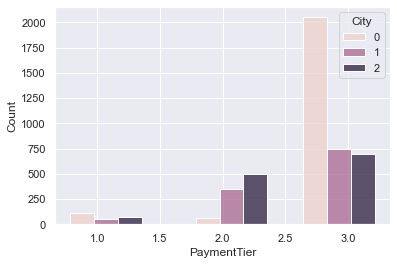

In [22]:
sns.histplot(data=df, x="PaymentTier", hue="City", multiple="dodge", shrink=4)

<AxesSubplot:ylabel='None'>

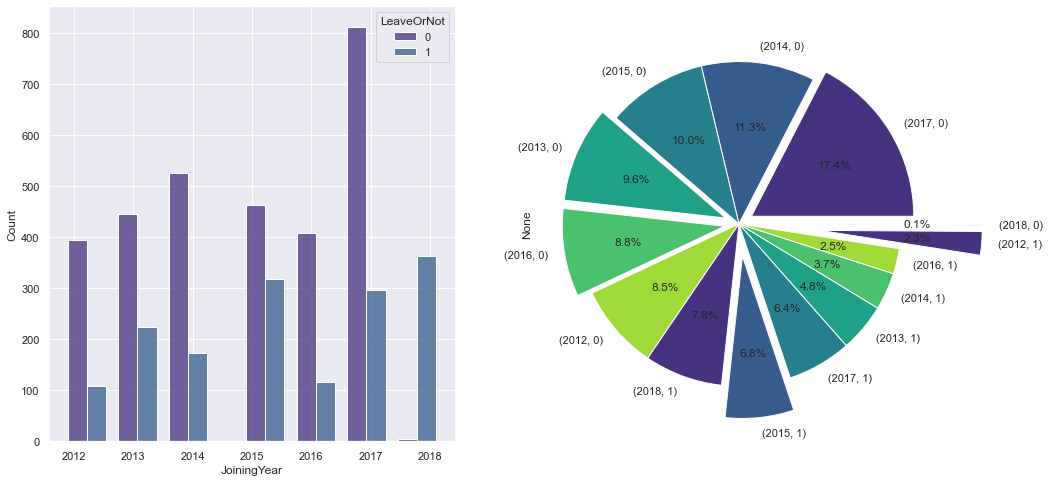

In [23]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
explode = [0.09,0.0,0.0,0.09,0.09,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.5,.5]
sns.histplot(data=df, x="JoiningYear", hue="LeaveOrNot", multiple="dodge", shrink=1.5, ax=axs[0])
(df[['JoiningYear','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] ,explode=explode)

### 2018 >>> all in 2017 leaving 
### 2012, 2016 is the lowest year 

<AxesSubplot:xlabel='PaymentTier', ylabel='Count'>

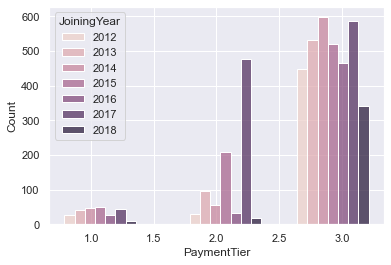

In [24]:
sns.histplot(data=df, x="PaymentTier", hue="JoiningYear", multiple="dodge", shrink=4)

<AxesSubplot:ylabel='None'>

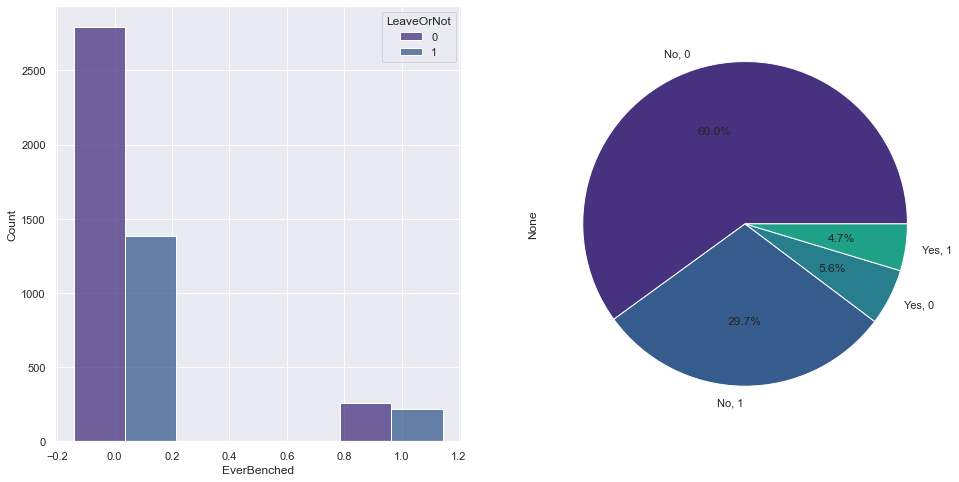

In [25]:
fig, axs = plt.subplots(ncols=2,figsize=(16, 8))
labels = ["No, 0", "No, 1", "Yes, 0", "Yes, 1"]
sns.histplot(data=df, x="EverBenched", hue="LeaveOrNot", multiple="dodge", shrink=5, ax=axs[0])
(df[['EverBenched','LeaveOrNot']].value_counts(normalize=True)*100).plot.pie(autopct='%1.1f%%', ax=axs[1] , labels = labels)

## it means ever kept out of the projects for 1 month or more
### 30% from not behanced leaving 
### 5.6% behanced and not leaving 


<AxesSubplot:xlabel='JoiningYear', ylabel='Count'>

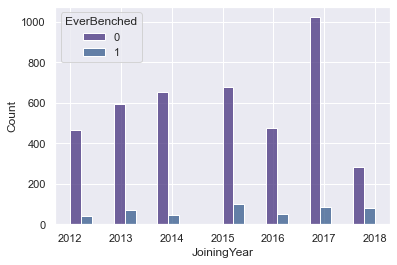

In [26]:
sns.histplot(data=df, x="JoiningYear", hue="EverBenched", multiple="dodge", shrink=1)

## Normalization, Over sampling, and Train-Test-split

In [27]:
sc= MinMaxScaler()
X =pd.DataFrame(sc.fit_transform(df.drop(["LeaveOrNot"],axis = 1)))
Y = df['LeaveOrNot'].values

In [28]:
sm = SMOTE(random_state=42)
X,Y=sm.fit_resample(X, Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2 , random_state=42)

# Modeling

##  1-LGBMClassifier

F1-Score: 0.8771929824561403
Accuracy: 0.8854337152209493
Precision: 0.9328358208955224
Recall: 0.8278145695364238
AUC: 0.8847810711759789
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       618
           1       0.93      0.83      0.88       604

    accuracy                           0.89      1222
   macro avg       0.89      0.88      0.88      1222
weighted avg       0.89      0.89      0.89      1222



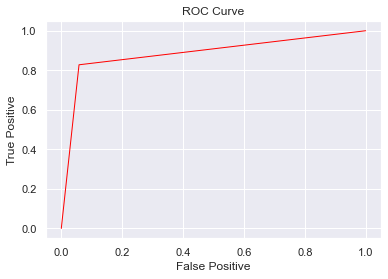

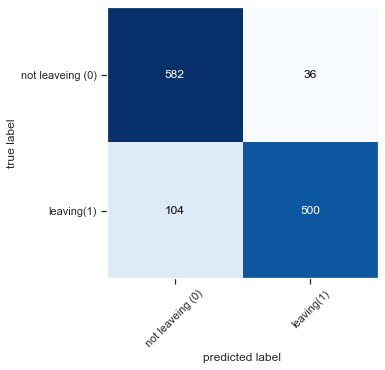

In [29]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, Y_train)
Y_pred_test = clf.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_test))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))
print("Precision:",metrics.precision_score(Y_test, Y_pred_test))
print("Recall:",metrics.recall_score(Y_test, Y_pred_test))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_test))
print(classification_report(Y_test, Y_pred_test))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_test,pos_label=1)
confusion_matrix=confusion_matrix(Y_test,Y_pred_test)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plot_confusion_matrix(confusion_matrix,class_names=["not leaveing (0)","leaving(1)"],figsize=(12,5))
plt.show()

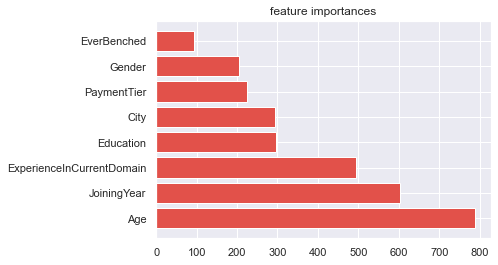

In [30]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()

features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain']
sns.set_theme(palette="Spectral")
f_importances(abs(clf.feature_importances_), features_names, top=8)

## in LGBMClassifier the best features for prediction is:
### 1- Age
### 2- Joining Year
### 3- Experience
### 4- City
### 5- Education
### 6- Payment Tier
### 7- Gender
### 8- Benching

## 2-KNeighborsClassifier

F1-Score: 0.8141745894554884
Accuracy: 0.8240589198036007
Precision: 0.8517179023508138
Recall: 0.7798013245033113
AUC: 0.8235576201804583
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       618
           1       0.85      0.78      0.81       604

    accuracy                           0.82      1222
   macro avg       0.83      0.82      0.82      1222
weighted avg       0.83      0.82      0.82      1222



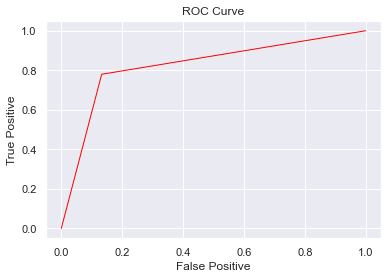

In [31]:
K=KNeighborsClassifier(n_neighbors=10)
K.fit(X_train, Y_train)
Y_pred_k = K.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_k))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_k))
print("Precision:",metrics.precision_score(Y_test, Y_pred_k))
print("Recall:",metrics.recall_score(Y_test, Y_pred_k))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_k))
print(classification_report(Y_test, Y_pred_k))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_k,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

## 3-DecisionTreeClassifier

F1-Score: 0.8313796212804329
Accuracy: 0.8469721767594108
Precision: 0.9128712871287129
Recall: 0.7632450331125827
AUC: 0.8460238110546733
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       618
           1       0.91      0.76      0.83       604

    accuracy                           0.85      1222
   macro avg       0.86      0.85      0.85      1222
weighted avg       0.86      0.85      0.85      1222



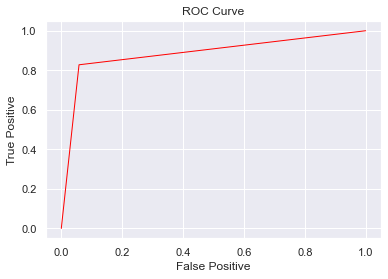

In [32]:
D=DecisionTreeClassifier(max_depth=8,max_features=8,random_state=42)
D.fit(X_train, Y_train)
Y_pred_d = D.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_d))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_d))
print("Precision:",metrics.precision_score(Y_test, Y_pred_d))
print("Recall:",metrics.recall_score(Y_test, Y_pred_d))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_d))
print(classification_report(Y_test, Y_pred_d))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_test,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

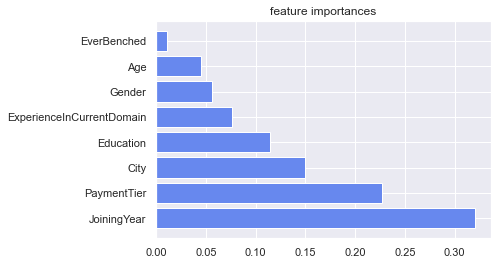

In [33]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()

features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain']
sns.set_theme(palette="coolwarm")
f_importances(abs(D.feature_importances_), features_names, top=8)

## in DecisionTreeClassifier the best features for prediction is:
### 1- Joining Year
### 2- Payment Tier
### 3- City
### 4- Education
### 5- Gender
### 6- Age
### 7- Experience
### 8- Benching

## 4-RandomForestClassifier

F1-Score: 0.8250226654578423
Accuracy: 0.8420621931260229
Precision: 0.9118236472945892
Recall: 0.7533112582781457
AUC: 0.8410569236374547
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       618
           1       0.91      0.75      0.83       604

    accuracy                           0.84      1222
   macro avg       0.85      0.84      0.84      1222
weighted avg       0.85      0.84      0.84      1222



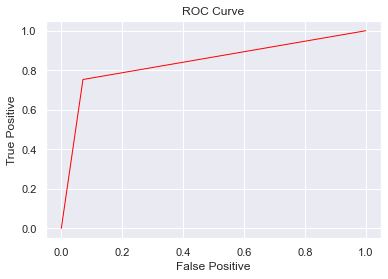

In [34]:
R=RandomForestClassifier(n_estimators=5,max_depth=8,max_features=8,random_state=42)
R.fit(X_train, Y_train)
Y_pred_r = R.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_r))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_r))
print("Precision:",metrics.precision_score(Y_test, Y_pred_r))
print("Recall:",metrics.recall_score(Y_test, Y_pred_r))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_r))
print(classification_report(Y_test, Y_pred_r))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_r,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

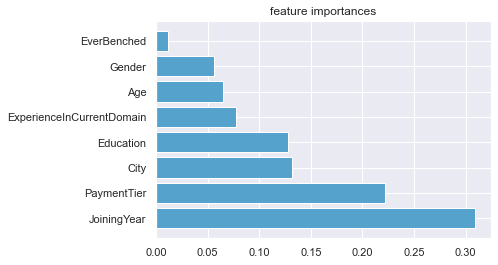

In [35]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()

features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain']
sns.set_theme(palette="icefire")
f_importances(abs(R.feature_importances_), features_names, top=8)

## in RandomForestClassifier the best features for prediction is:
### 1- Joining Year
### 2- Payment Tier
### 3- City
### 4- Education
### 5- Age
### 6- Gender
### 7- Experience
### 8- Benching

## 5-GradientBoostingClassifier

F1-Score: 0.8406840684068407
Accuracy: 0.8551554828150573
Precision: 0.9211045364891519
Recall: 0.7731788079470199
AUC: 0.8542269444265843
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       618
           1       0.92      0.77      0.84       604

    accuracy                           0.86      1222
   macro avg       0.86      0.85      0.85      1222
weighted avg       0.86      0.86      0.85      1222



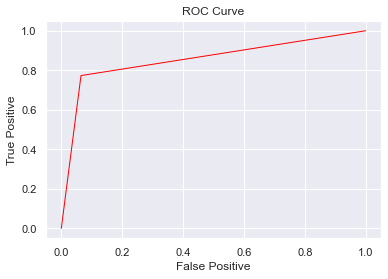

In [36]:
G=GradientBoostingClassifier(n_estimators =5, max_depth =7, learning_rate = 0.3, max_features=7,random_state=42 )
G.fit(X_train, Y_train)
Y_pred_g = G.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_g))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_g))
print("Precision:",metrics.precision_score(Y_test, Y_pred_g))
print("Recall:",metrics.recall_score(Y_test, Y_pred_g))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_g))
print(classification_report(Y_test, Y_pred_g))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_g,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

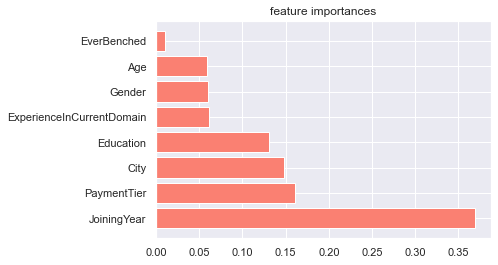

In [37]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()
    
features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain']
sns.set_theme(palette="dark:salmon_r")
f_importances(abs(G.feature_importances_), features_names, top=8)

## in GradientBoostingClassifier the best features for prediction is:
### 1- Joining Year
### 2- City
### 3- Payment Tier
### 4- Education
### 5- Gender
### 6- Age
### 7- Experience
### 8- Benching

## 6-Support Vector Machine

F1-Score: 0.8224799286351473
Accuracy: 0.837152209492635
Precision: 0.8916827852998066
Recall: 0.7632450331125827
AUC: 0.8363150731905956
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       618
           1       0.89      0.76      0.82       604

    accuracy                           0.84      1222
   macro avg       0.84      0.84      0.84      1222
weighted avg       0.84      0.84      0.84      1222



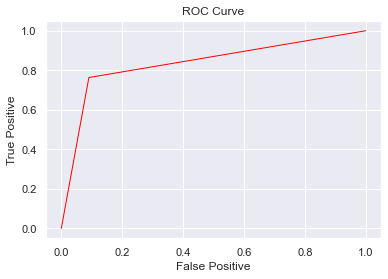

In [38]:
rbf = svm.SVC(kernel='rbf', gamma=4,C=2).fit(X_train,Y_train)
rbf.fit(X_train, Y_train)
Y_pred_rbf = rbf.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_rbf))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_rbf))
print("Precision:",metrics.precision_score(Y_test, Y_pred_rbf))
print("Recall:",metrics.recall_score(Y_test, Y_pred_rbf))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_rbf))
print(classification_report(Y_test, Y_pred_rbf))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_rbf,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

## 7-ExtraTreesClassifier

F1-Score: 0.8588850174216028
Accuracy: 0.867430441898527
Precision: 0.90625
Recall: 0.8162251655629139
AUC: 0.8668504468591268
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       618
           1       0.91      0.82      0.86       604

    accuracy                           0.87      1222
   macro avg       0.87      0.87      0.87      1222
weighted avg       0.87      0.87      0.87      1222



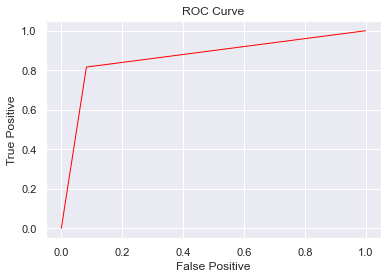

In [39]:
E = ExtraTreesClassifier(n_estimators=6,min_samples_split=10, random_state=0)
E.fit(X_train, Y_train)
Y_pred_e = E.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_e))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_e))
print("Precision:",metrics.precision_score(Y_test, Y_pred_e))
print("Recall:",metrics.recall_score(Y_test, Y_pred_e))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_e))
print(classification_report(Y_test, Y_pred_e))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_e,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

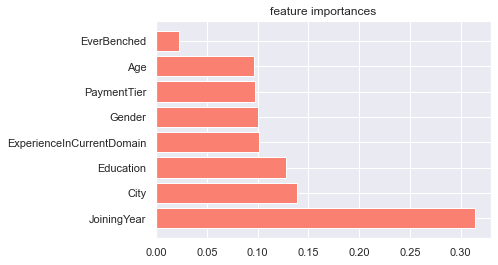

In [40]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()

features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain']
    
f_importances(abs(E.feature_importances_), features_names, top=8)

## in ExtraTreesClassifier the best features for prediction is:
### 1- Joining Year
### 2- City
### 3- Payment Tier
### 4- Education
### 5- Gender
### 6- Age
### 7- Experience
### 8- Benching

## 8-LogisticRegression

F1-Score: 0.6448979591836734
Accuracy: 0.644026186579378
Precision: 0.6360708534621579
Recall: 0.6539735099337748
AUC: 0.644138858526758
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       618
           1       0.64      0.65      0.64       604

    accuracy                           0.64      1222
   macro avg       0.64      0.64      0.64      1222
weighted avg       0.64      0.64      0.64      1222



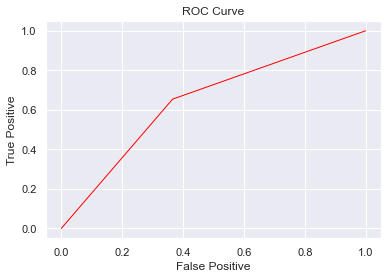

In [41]:
L=LogisticRegression()
L.fit(X_train, Y_train)
Y_pred_l = L.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_l))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_l))
print("Precision:",metrics.precision_score(Y_test, Y_pred_l))
print("Recall:",metrics.recall_score(Y_test, Y_pred_l))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_l))
print(classification_report(Y_test, Y_pred_l))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_l,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

## 9-AdaBoostClassifier

F1-Score: 0.7368421052631579
Accuracy: 0.7667757774140753
Precision: 0.8329853862212944
Recall: 0.6605960264900662
AUC: 0.7655730941511819
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       618
           1       0.83      0.66      0.74       604

    accuracy                           0.77      1222
   macro avg       0.78      0.77      0.76      1222
weighted avg       0.78      0.77      0.76      1222



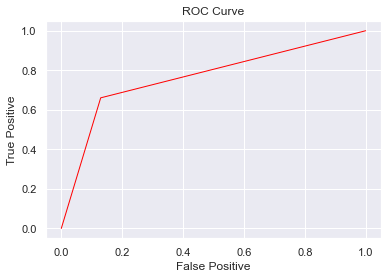

In [42]:
A=AdaBoostClassifier(n_estimators=5,learning_rate=.5)
A.fit(X_train, Y_train)
Y_pred_a = A.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_a))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_a))
print("Precision:",metrics.precision_score(Y_test, Y_pred_a))
print("Recall:",metrics.recall_score(Y_test, Y_pred_a))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_a))
print(classification_report(Y_test, Y_pred_a))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_a,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

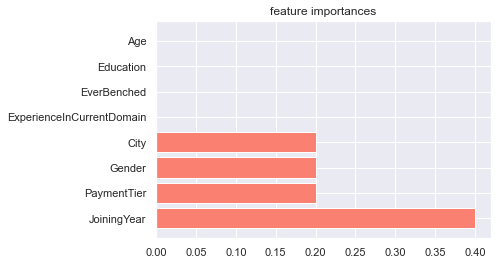

In [43]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances')
    plt.show()
features_names = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
  
                  'EverBenched', 'ExperienceInCurrentDomain']
f_importances(abs(A.feature_importances_), features_names, top=8)

## in AdaBoostClassifier the best features for prediction is:
### 1- Joining Year
### 2- Payment Tier , Gender , City

## 10-GaussianNB

F1-Score: 0.6453781512605041
Accuracy: 0.6546644844517185
Precision: 0.6552901023890785
Recall: 0.6357615894039735
AUC: 0.6544503739900127
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       618
           1       0.66      0.64      0.65       604

    accuracy                           0.65      1222
   macro avg       0.65      0.65      0.65      1222
weighted avg       0.65      0.65      0.65      1222



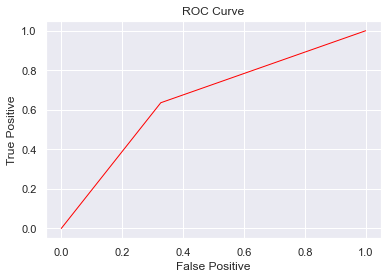

In [44]:
GNB = GaussianNB()
GNB.fit(X_train, Y_train)
Y_pred_gnb =GNB.predict(X_test)
print("F1-Score:",metrics.f1_score(Y_test, Y_pred_gnb))
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_gnb))
print("Precision:",metrics.precision_score(Y_test, Y_pred_gnb))
print("Recall:",metrics.recall_score(Y_test, Y_pred_gnb))
print("AUC:",metrics.roc_auc_score(Y_test, Y_pred_gnb))
print(classification_report(Y_test, Y_pred_gnb))
cutoff_grid = np.linspace(0.0,1.0,100)
TPR = []
FPR = []
cutoff_grid
FPR, TPR, cutoffs = metrics.roc_curve(Y_test, Y_pred_gnb,pos_label=1)
plt.plot(FPR,TPR,c='red',linewidth=1.0)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.show()

In [45]:
def testModel():
    edu = int(input("Please,Enter Education level\n0-Bachelors\n1-Masters\n2-PHD\n"))
    year = int(input("Please,Enter Joining year\n"))
    city = int(input("Please,Enter City\n0-Bangalore\n1-New Delhi\n2-Pune\n"))
    payment = int(input("Please,Enter Payment Tier\n1-Highest\n2-Mid Level\n3-Lowest\n"))
    age = int(input("Please,Enter Age\n"))
    gender = int(input("Please,Enter Gender\n0-Female\n1-Male\n"))
    benched = int(input("Please,Enter if employee ever Benched\n0-No\n1-Yes\n"))
    exper = int(input("Please,Enter Experience In Current Domain\n"))
    data = [[edu,year,city,payment,age,gender,benched,exper]]
    data = sc.transform(data)
    pred = clf.predict(data)
    if (pred == 1):
        print("Employee Will Leave\n")
        suge = int(input("Would you like to know the suggetions to make him stay?\n1-Yes\n2-No\n"))
        if(suge == 1):
            from random import choice
            while (1):
                data[0][1] = choice(X[1])
                data[0][2] = choice(X[2])
                data[0][3] = choice(X[3])
                data[0][6] = choice(X[6])
                sugPred = clf.predict(data)
                if (sugPred == 0):
                    data = (sc.inverse_transform(data)).astype(int)
                    data = data.astype(str)
                    if (data[0][2] == "0"):
                        data[0][2] = "Bangalore"
                    elif (data[0][2] == "1"):
                        data[0][2] = "New Delhi"
                    elif (data[0][2] == "2"):
                        data[0][2] = "Pune"
                    if (data[0][3] == "1"):
                        data[0][3] = "Highest"
                    elif (data[0][3] == "2"):
                        data[0][3] = "Mid"
                    elif (data[0][3] == "3"):
                        data[0][3] = "Lowest"
                    if (data[0][6] == "0"):
                        data[0][6] = " not "
                    elif (data[0][6] == "1"):
                        data[0][6] = " "
                    print("We suggest to deal with the employee like %s,\nmove the employee to office in %s,\nmake employee payment in %s level\nand%smake the employee benched\n" %(data[0][1] , data[0][2] , data[0][3] , data[0][6]))
                    break
    if (pred == 0):
        print("Employee will not leave")
testModel()

Please,Enter Education level
0-Bachelors
1-Masters
2-PHD
0
Please,Enter Joining year
2018
Please,Enter City
0-Bangalore
1-New Delhi
2-Pune
0
Please,Enter Payment Tier
1-Highest
2-Mid Level
3-Lowest
3
Please,Enter Age
28
Please,Enter Gender
0-Female
1-Male
1
Please,Enter if employee ever Benched
0-No
1-Yes
1
Please,Enter Experience In Current Domain
2
Employee Will Leave

Would you like to know the suggetions to make him stay?
1-Yes
2-No
1
We suggest to deal with the employee like 2012,
move the employee to office in New Delhi,
make employee payment in Lowest level
and not make the employee benched

